# HA 2

I understand that for most of you implementation paper process is a novelty. Let me give you some additional motivation for that issue.
 
A few words about how books are written. People involved in theoretical or practical research are never interested in writing books. Books are written in order to fulfill the formal requirement of universities to "create knowledge". And of course, you should not expect that a strong researcher will really qualitatively present the material. It is simply required of him. We all know how work is done that is "formally required". There is another culture for writing textbooks - books for sale. In this case, you should not expect that the author will reveal the entire depth of the material and really answer your urgent questions. Preparing material for students is a routine and dull job. So you should not expect that knowledge can easily be obtained from the educational literature.
 
On the other hand, there are popularizers of breakthrough methodologies. On the network you can find thousands of blogs about how this or that method works. This is certainly valuable material. But only auxiliary. The basis should always be well-structured, comprehensive material. By and large, to touch the real theoretical foundation of the method, we must read and repeat the results of the articles. The culture of publishing articles is aimed at this.

Naturally, not all articles are good. In science today there are a lot of fake specialists who write articles. And not every article can be tried to be taken as material for study.

Thus, the only way to study relevant materials is to read articles that are good and bad. And over time, you will learn to distinguish quality material from another article that is written to increase the formal KPI of the university.

The article (can be found in `topic3/`) that is offered to you is relatively good material. The authors are very famous specialists in mathematical and engineering science. The article is dated 2019. It remains to understand what is valuable in the article and how to read it. The article is devoted to the study of the Canonical Correlation Analysis for
Multilevel Time Series. First you need to break the article into logical parts.

### We are interested in sections

- **Introduction.** It gives motivation for presented algorithm.
- **CCA**. Review standard canonical correlation analysis problem and provide supportive theoremes.
- **Methodology**. Proposition of time dependent CCA (TDCCA). Yes we are going to implement it.
- **Experiments**. Authors provide several metrics, [code](https://github.com/xuefeicao/tdcca)  
  - Simulation 1 results (4.1.1)
  - Simulation 2 results (4.1.2)
  - Simulation results (4.1.3)
  

### Task

We are going to implement TDCCA algorithm. We are going to check algorithm on data and by using sufficient metrics. Motivation for sufficient metrics can be found in section `4.1` of the article. Thus we use:
- Correlation Deviation Ratio
- F1 Score
- Cosine of Angle
- Temporal Deviation Ratio

What about data. We are going to prepare artificial data (simulation). It means we need to generate our own data which is appropriate for proposed algorithm. Examples can be found in [authors repository](https://github.com/xuefeicao/tdcca/tree/master/examples). But let's agree. We can look at the authors repository, but we won't copy the code to generate the data. We will try to understand it, and based on it, create our own data generator that is suitable for this task. And of course we will not copy the original authors' code. We can spy on it, but we must create our own version.

**Copy-paste of the code is punishable by 0 points for home assignment** 

### Generate several cases of data for testing algorithm

In [20]:
#### YOUR CODE IS HERE
import numpy as np
import math
import scipy.linalg
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import roc_auc_score, f1_score


def sim1(t=100, d=4, n=100, generator_type="normal"):
    """
    t: number of vectors required default value 2, x,y
    d: d/4
    generator_type: ("normal", "noise", "related")
    returns:
        Xt_list: [x1, x2,....]
    """
    if generator_type == "normal":
        type1 = [1, -1, 0]
        type2 = [0, -1, 1, 0]
    elif generator_type == "noise":
        type1 = [0, 0, 0]
        type2 = [0, 0, 0, 0]
    elif generator_type == "related":
        type1 = [1, -1, 0, 0]
        type2 = [1, -1, 0, 0]
    else:
        print("No correct type of generator selected ")
        return

    Xt_list = []
    Wt_list = []
    three_pairs = False
    if t <= 100:
        three_pairs = True
        d_value = math.ceil(d / 4)
    else:
        d_value = math.ceil(d / 4)
    # Now we have value of 4
    for i in range(2 * t * n):
        # now build W for D_value
        if i < (t * n) or generator_type == 'related':
            # For first part we will start from 00
            # we are in type 1
            if i % 2 == 0:
                u = np.random.normal(0, 1)
                # first 1, -1, 0 and then
                w = [type1[0]] * d_value + [type1[1]] * d_value + [type1[2]] * int(d - d / 2)
            else:
                w = [type1[2]] * d_value * 2 + [type1[0]] * d_value + [type1[1]] * d_value  # *d_value
        else:
            # now in type 2
            if i % 2 == 0:
                u = np.random.normal(0, 1)
                # first  0, -1, 1, 0 and then
                w = [type2[0]] * d_value + [type2[1]] * d_value + [type2[2]] * d_value + [type2[3]] * d_value
            else:
                w = [type2[2]] * d_value + [type2[0]] * d_value * 2 + [type2[1]] * d_value
        w = np.array(w)
        # Now we have W for any case, now we should calculate the Xt
        # For Xt = (W xt + e1t )u t + η 1t
        # Randomly creating
        e = np.array([np.random.normal(0, 0.1) for i in range(len(w))])

        nu = np.array([np.random.normal(0, 0.1) for i in range(len(w))])

        # Now equation
        if generator_type == "noise":
            Xt = e + nu
        Xt = (w + e) * u + nu
        # Now add
        Xt_list.append(Xt)
        Wt_list.append(w)

    WX_true = np.transpose(np.array([i for j, i in enumerate(Wt_list) if j % 2 == 0]))
    WY_true = np.transpose(np.array([i for j, i in enumerate(Wt_list) if j % 2]))
    X = np.array([i for j, i in enumerate(Xt_list) if j % 2 == 0])
    Y = np.array([i for j, i in enumerate(Xt_list) if j % 2])

    print('********************************************************************')
    print(f'Data is simulated')
    print(f'X shape is {X.shape}')
    print(f'Y shape is {Y.shape}')
    print(f'WX_true shape is {WX_true.shape}')
    print(f'WY_true shape is {WY_true.shape}')
    return X, Y, WX_true, WY_true




In [10]:
from sklearn.preprocessing import normalize
def data_segmentation(data, T, W):
    '''
    We normilise our data then split it into chunks with dimension n x d
    For every chunk we generateSVD decomposition matricies. We are cutting our sigmas with 95% influence. 
    At the end we got:
    { X:
        { X1, X2, ... , Xt{
                            P,
                            Q,
                            Sigma1,
                            W_real,
                            U
                            }
        }
    
     Y: ... } 
    '''
    X = normalize(data[0], axis=0, norm='l2')
    Y = normalize(data[1], axis=0, norm='l2')
    Wx = data[2]
    Wy = data[3]
    DicTionary = {}
    DicTionary[0] = []
    DicTionary[1] = []
    x_data = []
    y_data = []
    wx_data = []
    wy_data = []
    ## check if step T is more then
    for g in range(((len(X) - T) // W) + 1):
        x_data.append(X[W * g: W * g + T])
        wx_data.append(Wx[:, W * g: W * g + T][:, 0])
    for g in range(((len(Y) - T) // W) + 1):
        y_data.append(Y[W * g: W * g + T])
        wy_data.append(Wy[:, W * g: W * g + T][:, 0])

    def find_cut(sigma, lambda_tol=0.95):
        squared_sigma = sigma ** 2
        element_sum = np.sum(squared_sigma)

        deposit = 0
        for number, element in enumerate(squared_sigma):
            deposit += element
            if deposit / element_sum >= lambda_tol or (
                    number > 1 and squared_sigma[number - 1] / squared_sigma[number] > 1e4):
                return number + 1
        return len(squared_sigma)

    for g in range(len(y_data)):
        Q1, Sigma1, U1_T = scipy.linalg.svd(x_data[g], compute_uv=True, full_matrices=False)
        U1 = np.transpose(U1_T)
        cut_index = find_cut(Sigma1)
        Q1, Sigma1, U1 = Q1[:, :cut_index], Sigma1[:cut_index], U1[:, :cut_index]
        Sigma1 = np.diag(Sigma1)

        Q2, Sigma2, V1_T = scipy.linalg.svd(y_data[g], compute_uv=True, full_matrices=False)
        V1 = np.transpose(V1_T)
        cut_index = find_cut(Sigma2)
        Q2, Sigma2, V1 = Q2[:, :cut_index], Sigma2[:cut_index], V1[:, :cut_index]
        Sigma2 = np.diag(Sigma2)

        P1, Sigma, P2_T = scipy.linalg.svd(np.transpose(Q1) @ Q2, compute_uv=True, full_matrices=False)
        P2 = np.transpose(P2_T)

        DicTionary[0].append({'U': U1, 'Q': Q1, 'Sigma': Sigma1, 'X': x_data[g], 'P': P1, 'W_real': wx_data[g]})
        DicTionary[1].append({'U': V1, 'Q': Q2, 'Sigma': Sigma2, 'X': y_data[g], 'P': P2, 'W_real': wy_data[g]})

    print('********************************************************************')
    print('Data is segmentated')

    print(f'Returned list consists of {len(DicTionary)} dictionaries for X and Y respectefully')
    for i in range(2):
        print('***')
        print(f'Dictionary for X{i} consists of {len(DicTionary[i])} dictionaries each corresponding to time t')
        print(f"In each dictionary lies {len(DicTionary[i][0])} parameters: \n \
        X of shape {DicTionary[i][0]['X'].shape} \n \
        U of shape {DicTionary[i][0]['U'].shape} \n \
        Q of shape {DicTionary[i][0]['Q'].shape} \n \
        Sigma of shape {DicTionary[i][0]['Sigma'].shape} \n \
        P of shape {DicTionary[i][0]['P'].shape} \n \
        W_real of shape {DicTionary[i][0]['W_real'].shape}")
    return DicTionary

### Provide code for calculation aforementioned metrics

### Code TDCCA class and `goes_brrrr` method for calculation correlations 

In [3]:
import prox_tv
from scipy.spatial.distance import cosine
import warnings
warnings.filterwarnings("ignore")

class TDCCA():
    def __init__(self, data, lambda_, mu, l, nu, fully=False):
        self.data = data
        self.T = len(data[0])
        # нужно продумать случаи для разных d1 и d2
        self.d = data[0][0]['X'].shape[1]
        self.mu_second_run = mu
        self.mu = 1e-13
        self.fully = fully
        self.l = l
        self.lambda_ = lambda_
        self.nu = nu
        self.W_real = np.zeros((2, 1, self.data[0][0]['W_real'].shape[0], len(self.data[0])))
        for i in range(2):
            for t in range(len(data[i])):
                self.W_real[i, 0, :, t] = data[i][t]['W_real']

        self.val_X = np.array([i['X'] for i in self.data[0]])
        self.val_Y = np.array([i['X'] for i in self.data[1]])
        self.val_data = np.array([self.val_X, self.val_Y])

        self.D = np.zeros((self.T, self.T - 1))
        for i in range(self.T - 1):
            self.D[i][i] = 1
            self.D[i + 1][i] = -1

        self.W = np.zeros((2, self.l, self.d, self.T))  # np.random.uniform(-1.0,1.0,(2,self.l,self.d,self.T))

        self.W = np.zeros((2, self.l, self.d, self.T))  # np.random.uniform(-1.0,1.0,(2,self.l,self.d,self.T))
        self.W_hat = np.zeros((2, self.l, self.d, self.T))  # np.random.uniform(-1.0, 1.0,(2, self.l, self.d, self.T))
        self.W_tilda = np.zeros((2, self.l, self.d, self.T))  # np.random.uniform(-1.0,1.0,(2,self.l,self.d,self.T))
        self.Phi = np.zeros((2, self.l, self.d, self.T))  # np.random.uniform(-1.0,1.0,(2,self.l,self.d,self.T))
        self.Theta = np.zeros((2, self.l, self.d, self.T))  # np.random.uniform(-1.0,1.0,(2,self.l,self.d,self.T))
    def admm(self, l, i, n_iters,for_graphic=True):
        print('********************************************************************')
        print(f'start of admm for canonical pair {l} and i = {i}')
        print('********************************************************************')
        loss_ray = []
        iter_numb = []  
        score_f = []
        cos_v = []
        for k in range(n_iters):
            if k <100:
                iter_numb.append(k)
#                 try:
                if not self.fully:
                    roc_auc, f_score = self.eval_zero(self.W, 2, self.T, self.l, self.W_real)
                    score_f.append(f_score)
#                 except ValueError:
#                     pass

                if for_graphic % 2 == 0:
                # cos_v.append(self.cosine_of_angle(l)[1])
                    loss_ray.append(self.loss_fun(l)[1])
                else:
                    loss_ray.append(self.loss_fun(l)[0])
                # cos_v.append(self.cosine_of_angle(l)[0])
                
            if k % 40 == 0:

                loss = self.loss_fun(l)
                cos = self.cosine_of_angle(l)
                TDR = self.TDR(l)
                
                CDR, mean_corr = self.CDR(l)
                if not self.fully:
                    roc_auc, f_score = self.eval_zero(self.W, 2, self.T, self.l, self.W_real)
                    print(f'iter: {k}, loss X:{loss[0]:.2f}, loss Y:{loss[1]:.2f}, cos X:{cos[0]:.2f}, cos Y:{cos[1]:.2f}, TDR:{TDR:.2f}, \
F_score:{f_score:.2f}, roc_auc:{roc_auc:.2f}, CDR:{CDR:.4f}, Mean Absolute Correlation:{mean_corr:.2f}')
                else:
                    print(f'iter: {k}, loss X:{loss[0]:.2f}, loss Y:{loss[1]:.2f}, cos X:{cos[0]:.2f}, cos Y:{cos[1]:.2f}, TDR:{TDR:.2f}, \
CDR:{CDR:.4f}, Mean Absolute Correlation:{mean_corr:.2f}')

            # Step 1
            for t in range(self.T):
                X = self.data[i][t]['X']
                Q = self.data[i][t]['Q']
                Sigma = self.data[i][t]['Sigma']
                U = self.data[i][t]['U']
                P = self.data[i][t]['P']

                X1 = np.linalg.inv(U @ np.transpose(U) + 2 * self.nu * np.eye(U.shape[0], U.shape[0]))
                X2 = (-self.Phi[i, l, :, t] - self.Theta[i, l, :, t] + U @ np.linalg.inv(Sigma) @ P[:, l] + self.nu * (
                            self.W_hat[i, l, :, t] + self.W_tilda[i, l, :, t]))
                self.W[i, l, :, t] = X1 @ X2

            # Step 2
            self.W_tilda[i, l] = np.sign(self.W[i, l] + self.Theta[i, l] / self.nu) * np.maximum(
                np.absolute(self.W[i, l] + self.Theta[i, l] / self.nu) - self.lambda_ / self.nu, 0)

            # Step 3
            tmp = self.W[i, l] + 1.0 * self.Phi[i, l] / self.nu

            for j in range(self.d):
                self.W_hat[i, l, j, :] = prox_tv.tv1_1d(tmp[j, :], 1.0 * self.mu / self.nu)

            # Step 4
            self.Theta[i, l] += self.nu * (self.W[i, l] - self.W_tilda[i, l])

            # Step 5
            self.Phi[i, l] += self.nu * (self.W[i, l] - self.W_hat[i, l])
#             print (iter_numb)

        # Plot charts of Loss and F1-Score
        if not self.fully:
            plt.figure
            plt.plot(iter_numb[:30], score_f[:30], linestyle='solid') 
            plt.grid()
            plt.ylim(ymin=0) 
            plt.title ("F_score")
            plt.show()

        plt.figure
        plt.plot(iter_numb, loss_ray, linestyle='solid') 
        # plt.ylim(ymin=0) 
        plt.grid()
        if for_graphic % 2 == 0:
          plt.title ("loss Y")
          plt.show()

          # plt.figure 
          # plt.plot(iter_numb, cos_v, linestyle='solid') 
          # plt.grid()
          # plt.title ("Cos_ Y")  
          # plt.show()
        else:
          plt.title ("loss X")
          plt.show()
          
          # plt.figure 
          # plt.plot(iter_numb, cos_v, linestyle='solid') 
          # plt.grid()
          # plt.title ("Cos_ X")  
          # plt.show()
        return self.W

    def goes_brrrr(self, n_iters=100):
        ## Calculate
        for_graphic = 0 
        for i in range(2):
            for_graphic += 1
            for l in range(self.l):
                self.admm(l, i, n_iters, for_graphic)

    def loss_fun(self, l):
        loss = np.array([0.0, 0.0])

        for i in range(2):
            W = self.W[i, l, :, :]
            W_hat = self.W_hat[i, l, :, :]
            W_tilda = self.W_tilda[i, l, :, :]
            Theta = self.Theta[i, l, :, :]
            Phi = self.Phi[i, l, :, :]
            D = self.D
            for t in range(self.T):
                U = self.data[i][t]['U']
                Sigma = self.data[i][t]['Sigma']
                Sigma_inv = np.linalg.inv(Sigma)  # maybe store Sigma inv nstead of sigma?
                P = self.data[i][t]['P'][:, l]
                loss[i] += self.F_sq(np.transpose(U) @ W[:, t] - Sigma_inv @ P)

            loss[i] += self.lambda_ * self.l1(W_tilda)
            loss[i] += self.mu * self.l1(W_hat @ D)
            loss[i] += np.trace(np.transpose(Theta) @ (W - W_tilda))
            loss[i] += np.trace(np.transpose(Phi) @ (W - W_hat))
            loss[i] += self.nu / 2 * (self.F_sq(W - W_tilda) + self.F_sq(W - W_hat))
        return loss

    def l1(self, X):
        return np.sum(abs(X))

    def F_sq(self, X):
        return np.square(np.linalg.norm(X))

    def algoritm_2(self, n_iters):
        print('********************************************************************')
        print(f'start first admm for mu = {self.mu}')
        self.goes_brrrr(n_iters)
        Wx = self.W[0]
        Wy = self.W[1]
        for l in range(self.l):
            for t in range(1, self.T):
                if self.l1(Wx[l, :, t - 1] - Wx[l, :, t]) + self.l1(Wy[l, :, t - 1] - Wy[l, :, t]) > self.l1(
                        Wx[l, :, t - 1] + Wx[l, :, t]) + self.l1(Wy[l, :, t - 1] + Wy[l, :, t]):
                    self.data[0][t]['P'][:, l] *= -1
                    self.data[1][t]['P'][:, l] *= -1
                # if np.sum(abs(self.W[0,0,:, t] + self.W_hat[0,0,:, t - 1])) + np.sum(abs(self.W[1,0,:, t] + self.W_hat[1,0,:, t - 1])) < (
                #         np.sum(abs(self.W_hat[0,0,:, t] - self.W_hat[0,0,:, t - 1])) + np.sum(abs(self.W_hat[1,0,:, t] - self.W_hat[1,0,:, t - 1]))):
                #     self.W[0,0,:, t], self.W_tilda[0,0,:, t], self.W_hat[0,0,:, t] = -self.W[0,0,:, t], -self.W_tilda[0,0,:, t], -self.W_hat[0,0,:, t]
                #     self.W[1,0,:, t], self.W_tilda[1,0,:, t], self.W_hat[1,0,:, t] = -self.W[1,0,:, t], -self.W_tilda[1,0,:, t], -self.W_hat[1,0,:, t]

        self.mu = self.mu_second_run
        print('********************************************************************')
        print(f'start second admm for mu = {self.mu}')
        self.goes_brrrr(n_iters)
        return self.W

    def eval_zero(self, W, N, T, l, real_W):

        s = 0
        s1 = 0

        for ll in range(l):
            for i in range(N):
                tmp = W[(i, ll)]
                if np.isnan(tmp).any():
                    return 0, 0
                for t in range(T):
                    try:
                        s += self.fd_1(real_W[(i, ll)][:, t], tmp[:, t])
                        s1 += f1_score(abs(real_W[(i, ll)][:, t]) > 0.1, abs(tmp[:, t]) > 0.1)
                    except ValueError:
                        s += np.sum(abs(tmp[:, t]) > 0.1)
                        s1 += np.sum(abs(tmp[:, t]) > 0.1)
                        
        return s / (N * T * l), s1 / (N * T * l)

    def fd_1(self, A1, A):
        if np.sum(abs(A1)) < 1e-32:
            return -1
        tmp = abs(A)
        if np.max(tmp) == 0:
            tmp = tmp
        else:
            tmp = tmp / np.max(tmp)
        A1 = (abs(A1) > 0.1)
        sr = roc_auc_score(A1.reshape((-1)), tmp.reshape((-1)))
        return sr

    def cosine_of_angle(self, l):
        similarity = np.array([0.0, 0.0])
        for i in range(2):
            for t in range(self.T):
                X = self.data[i][t]['X']
                W = self.W[i, l, :, t]
                W_real = self.data[i][t]['W_real']
                ### здесь ничего не обновляется не пойму почему
                similarity[i] += np.abs(1 - cosine(X @ W, X @ W_real))
            #                 if i == 0:
            #                     print(cosine(X@W, X@W_real))
            similarity[i] /= self.T
        return similarity

    def CDR(self, l):
        ratios = []
        pred_corrs = []
        for t in range(100):
            Xt = self.data[0][t]['X']
            Yt = self.data[1][t]['X']
            Wxt_real = self.data[0][t]['W_real']
            Wyt_real = self.data[1][t]['W_real']
            p_real, _ = stats.pearsonr(np.transpose(Wxt_real) @ np.transpose(Xt),
                                       np.transpose(Wyt_real) @ np.transpose(Yt))
            Wxt = self.W[0, l, :, t]
            Wyt = self.W[1, l, :, t]
            p_pred, _ = stats.pearsonr(np.transpose(Wxt) @ np.transpose(Xt), np.transpose(Wyt) @ np.transpose(Yt))
            ratio = self.l1(p_real - p_pred) / p_real
            ratios.append(ratio)
            pred_corrs.append(np.abs(p_pred))
        return np.mean(ratios), np.mean(pred_corrs)

    def TDR(self, l):
        Wx = self.W[0]
        Wy = self.W[1]
        values = []
        max_val = 0
        for t in range(1, self.T):
            v = self.l1(abs(Wx[:, :, t] - Wx[:, :, t - 1])) + self.l1(abs(Wy[:, :, t] - Wy[:, :, t - 1]))
            values.append(v)
            if t == 51:
                max_val = v
        return np.max(values) / np.mean(values)

In [4]:
#hyper_parameters of the algotrithm
nu = 10
lam = 0.001
mu = 0.002

### Plotting function

In [14]:
import pandas as pd
import seaborn as sns
def plot_graphs(simulated_data):
    d1 = simulated_data[0].shape[1]
    d = {'X1': simulated_data[0][ :: 100 ,1] , 
         'X2': simulated_data[0][ :: 100 ,d1//4], 
         'X3': simulated_data[0][ :: 100 ,d1//2], 
         'X4': simulated_data[0][ :: 100 ,d1-1],
         'Y1': simulated_data[1][ :: 100 ,1] , 
         'Y2': simulated_data[1][ :: 100 ,d1//4], 
         'Y3': simulated_data[1][ :: 100 ,d1//2], 
         'Y4': simulated_data[1][ :: 100 ,d1-1],
        }
    df = pd.DataFrame(data=d)
    sns.pairplot(df)

### Simulation of data with changing changing correlation

********************************************************************
Data is simulated
X shape is (10000, 20)
Y shape is (10000, 20)
WX_true shape is (20, 10000)
WY_true shape is (20, 10000)
********************************************************************
Data is segmentated
Returned list consists of 2 dictionaries for X and Y respectefully
***
Dictionary for X0 consists of 100 dictionaries each corresponding to time t
In each dictionary lies 6 parameters: 
         X of shape (100, 20) 
         U of shape (20, 6) 
         Q of shape (100, 6) 
         Sigma of shape (6, 6) 
         P of shape (6, 6) 
         W_real of shape (20,)
***
Dictionary for X1 consists of 100 dictionaries each corresponding to time t
In each dictionary lies 6 parameters: 
         X of shape (100, 20) 
         U of shape (20, 6) 
         Q of shape (100, 6) 
         Sigma of shape (6, 6) 
         P of shape (6, 6) 
         W_real of shape (20,)


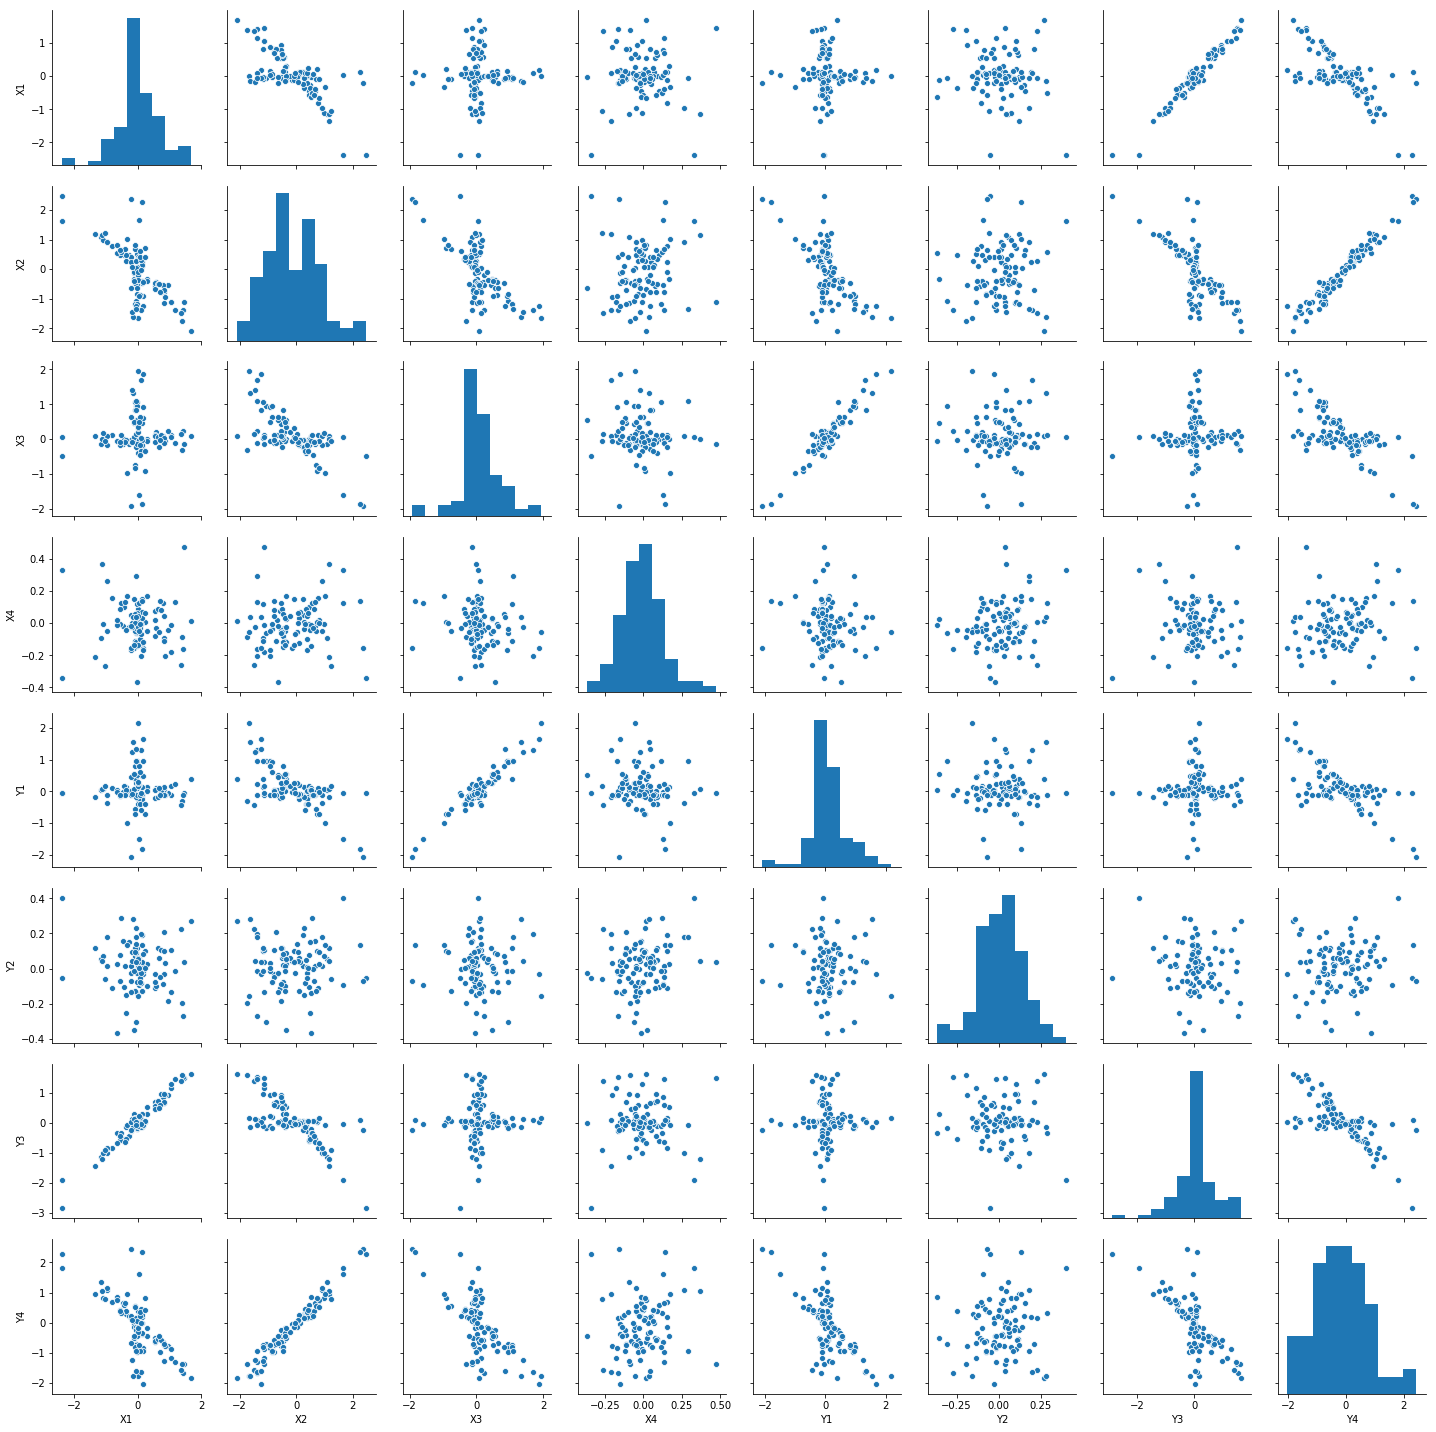

In [15]:
simulated_data = sim1(t = 100, d = 20, n =100,generator_type='normal')
segmented_data = data_segmentation( simulated_data, T = 100, W = 100)

plot_graphs(simulated_data)

********************************************************************
********************************************************************
Evaluation for lamba = 0.001 and mu = 0.002
********************************************************************
start first admm for mu = 1e-13
********************************************************************
start of admm for canonical pair 0 and i = 0
********************************************************************
iter: 0, loss X:702.67, loss Y:701.57, cos X:nan, cos Y:nan, TDR:nan, F_score:0.00, roc_auc:0.50, CDR:nan, Mean Absolute Correlation:nan
iter: 40, loss X:15.13, loss Y:701.57, cos X:1.00, cos Y:nan, TDR:2.20, F_score:0.48, roc_auc:0.75, CDR:nan, Mean Absolute Correlation:nan
iter: 80, loss X:1.16, loss Y:701.57, cos X:1.00, cos Y:nan, TDR:2.21, F_score:0.48, roc_auc:0.75, CDR:nan, Mean Absolute Correlation:nan
iter: 120, loss X:0.87, loss Y:701.57, cos X:1.00, cos Y:nan, TDR:2.21, F_score:0.48, roc_auc:0.75, CDR:nan, Mean Absolu

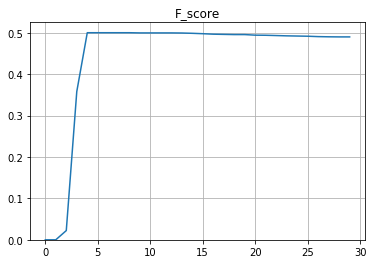

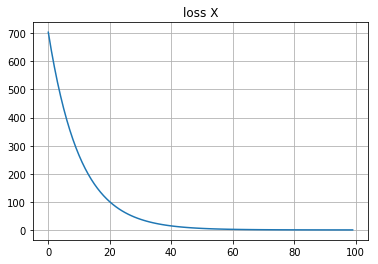

********************************************************************
start of admm for canonical pair 0 and i = 1
********************************************************************
iter: 0, loss X:0.85, loss Y:701.57, cos X:1.00, cos Y:nan, TDR:2.22, F_score:0.48, roc_auc:0.75, CDR:nan, Mean Absolute Correlation:nan
iter: 40, loss X:0.85, loss Y:15.10, cos X:1.00, cos Y:1.00, TDR:2.22, F_score:0.96, roc_auc:1.00, CDR:0.0002, Mean Absolute Correlation:1.00
iter: 80, loss X:0.85, loss Y:1.16, cos X:1.00, cos Y:1.00, TDR:2.22, F_score:0.95, roc_auc:1.00, CDR:0.0001, Mean Absolute Correlation:1.00
iter: 120, loss X:0.85, loss Y:0.87, cos X:1.00, cos Y:1.00, TDR:2.22, F_score:0.95, roc_auc:1.00, CDR:0.0001, Mean Absolute Correlation:1.00
iter: 160, loss X:0.85, loss Y:0.86, cos X:1.00, cos Y:1.00, TDR:2.22, F_score:0.95, roc_auc:1.00, CDR:0.0001, Mean Absolute Correlation:1.00
iter: 200, loss X:0.85, loss Y:0.86, cos X:1.00, cos Y:1.00, TDR:2.22, F_score:0.95, roc_auc:1.00, CDR:0.0001, Me

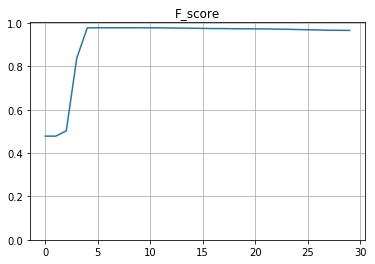

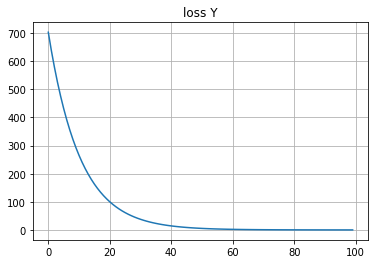

********************************************************************
start second admm for mu = 0.002
********************************************************************
start of admm for canonical pair 0 and i = 0
********************************************************************
iter: 0, loss X:1311.90, loss Y:1311.59, cos X:1.00, cos Y:1.00, TDR:2.22, F_score:0.96, roc_auc:1.00, CDR:0.0001, Mean Absolute Correlation:1.00
iter: 40, loss X:29.05, loss Y:1311.59, cos X:1.00, cos Y:1.00, TDR:1.94, F_score:0.96, roc_auc:1.00, CDR:0.9401, Mean Absolute Correlation:1.00
iter: 80, loss X:3.17, loss Y:1311.59, cos X:1.00, cos Y:1.00, TDR:2.08, F_score:0.96, roc_auc:1.00, CDR:0.9401, Mean Absolute Correlation:1.00
iter: 120, loss X:2.61, loss Y:1311.59, cos X:1.00, cos Y:1.00, TDR:2.10, F_score:0.95, roc_auc:1.00, CDR:0.9401, Mean Absolute Correlation:1.00
iter: 160, loss X:2.58, loss Y:1311.59, cos X:1.00, cos Y:1.00, TDR:2.10, F_score:0.95, roc_auc:1.00, CDR:0.9401, Mean Absolute Correla

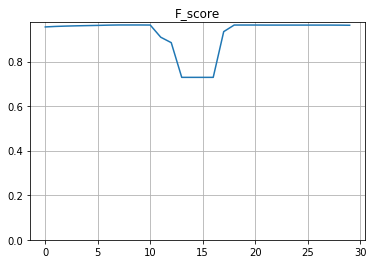

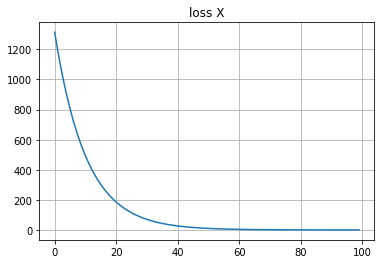

********************************************************************
start of admm for canonical pair 0 and i = 1
********************************************************************
iter: 0, loss X:2.53, loss Y:1311.59, cos X:1.00, cos Y:1.00, TDR:2.09, F_score:0.96, roc_auc:1.00, CDR:0.9401, Mean Absolute Correlation:1.00
iter: 40, loss X:2.53, loss Y:29.05, cos X:1.00, cos Y:1.00, TDR:2.16, F_score:0.96, roc_auc:1.00, CDR:0.0002, Mean Absolute Correlation:1.00
iter: 80, loss X:2.53, loss Y:3.17, cos X:1.00, cos Y:1.00, TDR:2.15, F_score:0.96, roc_auc:1.00, CDR:0.0002, Mean Absolute Correlation:1.00
iter: 120, loss X:2.53, loss Y:2.61, cos X:1.00, cos Y:1.00, TDR:2.15, F_score:0.96, roc_auc:1.00, CDR:0.0002, Mean Absolute Correlation:1.00
iter: 160, loss X:2.53, loss Y:2.58, cos X:1.00, cos Y:1.00, TDR:2.15, F_score:0.96, roc_auc:1.00, CDR:0.0001, Mean Absolute Correlation:1.00
iter: 200, loss X:2.53, loss Y:2.58, cos X:1.00, cos Y:1.00, TDR:2.15, F_score:0.96, roc_auc:1.00, CDR:0.00

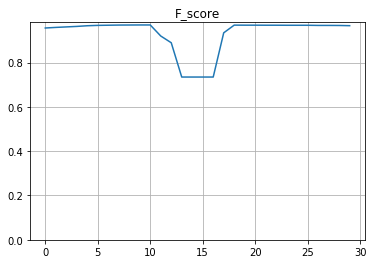

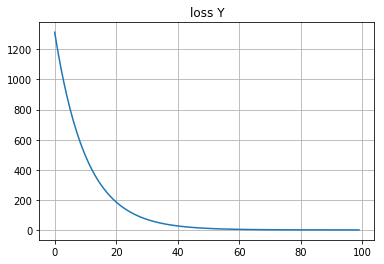

In [46]:
print('********************************************************************')
print('********************************************************************')
print(f'Evaluation for lamba = {i} and mu = {j}')
params = {'data':segmented_data,
          'lambda_': i,
          'mu': j,
          'l':1,
         'nu':10}
tdcca = TDCCA(**params)
W = tdcca.algoritm_2(n_iters=2000)

### Simulation of fully correlated data

********************************************************************
Data is simulated
X shape is (10000, 20)
Y shape is (10000, 20)
WX_true shape is (20, 10000)
WY_true shape is (20, 10000)
********************************************************************
Data is segmentated
Returned list consists of 2 dictionaries for X and Y respectefully
***
Dictionary for X0 consists of 100 dictionaries each corresponding to time t
In each dictionary lies 6 parameters: 
         X of shape (100, 20) 
         U of shape (20, 10) 
         Q of shape (100, 10) 
         Sigma of shape (10, 10) 
         P of shape (10, 10) 
         W_real of shape (20,)
***
Dictionary for X1 consists of 100 dictionaries each corresponding to time t
In each dictionary lies 6 parameters: 
         X of shape (100, 20) 
         U of shape (20, 10) 
         Q of shape (100, 10) 
         Sigma of shape (10, 10) 
         P of shape (10, 10) 
         W_real of shape (20,)


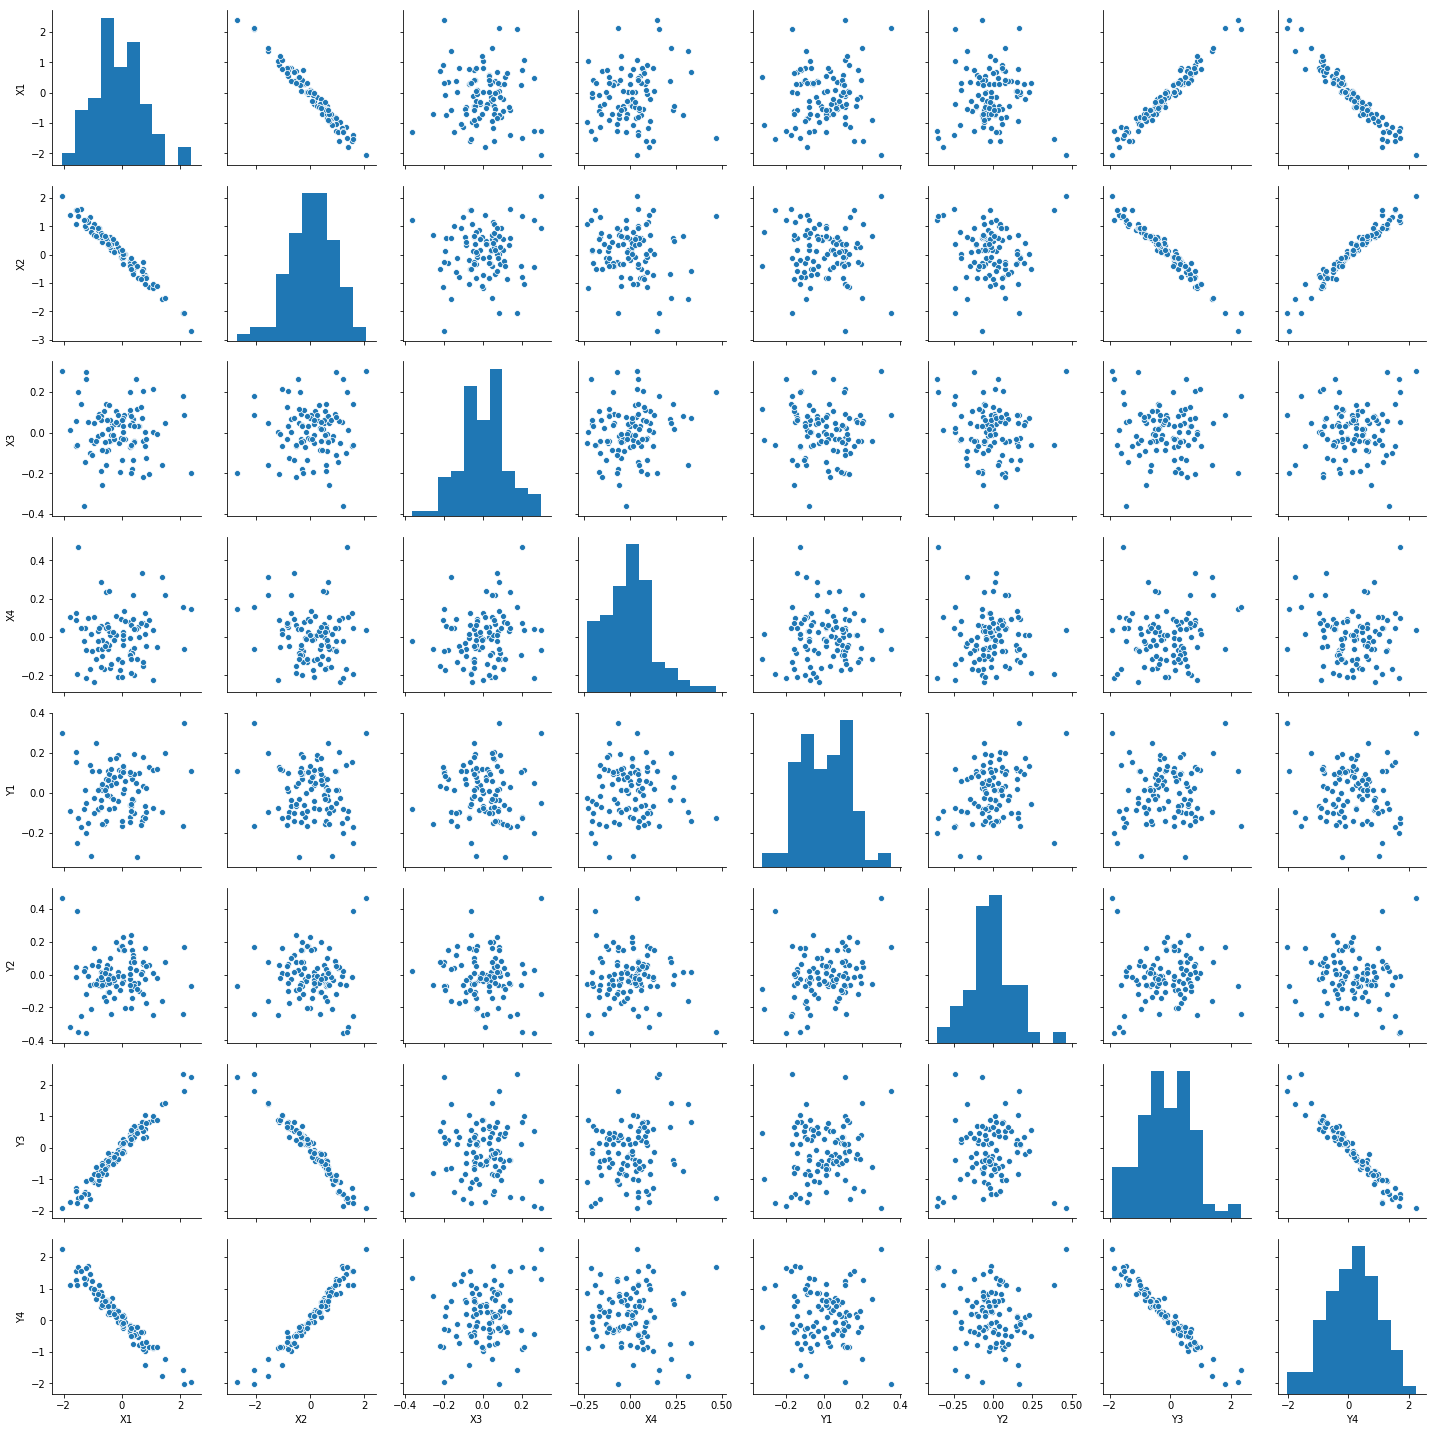

In [21]:
simulated_data = sim1(t = 100, d = 20, n =100,generator_type='related')
segmented_data = data_segmentation( simulated_data, T = 100, W = 100)
plot_graphs(simulated_data)

********************************************************************
********************************************************************
Evaluation for lamba = 0.001 and mu = 0.002
********************************************************************
start first admm for mu = 1e-13
********************************************************************
start of admm for canonical pair 0 and i = 0
********************************************************************
iter: 0, loss X:518.65, loss Y:518.81, cos X:nan, cos Y:nan, TDR:nan, CDR:nan, Mean Absolute Correlation:nan
iter: 40, loss X:11.58, loss Y:518.81, cos X:1.00, cos Y:nan, TDR:1.86, CDR:nan, Mean Absolute Correlation:nan
iter: 80, loss X:1.25, loss Y:518.81, cos X:1.00, cos Y:nan, TDR:1.86, CDR:nan, Mean Absolute Correlation:nan
iter: 120, loss X:1.02, loss Y:518.81, cos X:1.00, cos Y:nan, TDR:1.86, CDR:nan, Mean Absolute Correlation:nan
iter: 160, loss X:1.02, loss Y:518.81, cos X:1.00, cos Y:nan, TDR:1.86, CDR:nan, Mean Absolut

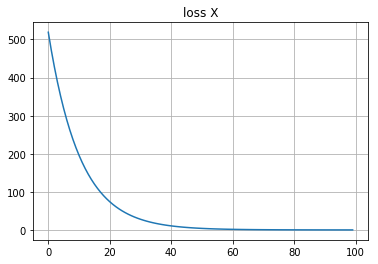

********************************************************************
start of admm for canonical pair 0 and i = 1
********************************************************************
iter: 0, loss X:1.02, loss Y:518.81, cos X:1.00, cos Y:nan, TDR:1.86, CDR:nan, Mean Absolute Correlation:nan
iter: 40, loss X:1.02, loss Y:11.59, cos X:1.00, cos Y:1.00, TDR:1.86, CDR:0.0000, Mean Absolute Correlation:1.00
iter: 80, loss X:1.02, loss Y:1.25, cos X:1.00, cos Y:1.00, TDR:1.86, CDR:0.0000, Mean Absolute Correlation:1.00
iter: 120, loss X:1.02, loss Y:1.02, cos X:1.00, cos Y:1.00, TDR:1.86, CDR:0.0000, Mean Absolute Correlation:1.00
iter: 160, loss X:1.02, loss Y:1.02, cos X:1.00, cos Y:1.00, TDR:1.86, CDR:0.0000, Mean Absolute Correlation:1.00
iter: 200, loss X:1.02, loss Y:1.02, cos X:1.00, cos Y:1.00, TDR:1.86, CDR:0.0000, Mean Absolute Correlation:1.00
iter: 240, loss X:1.02, loss Y:1.02, cos X:1.00, cos Y:1.00, TDR:1.86, CDR:0.0000, Mean Absolute Correlation:1.00
iter: 280, loss X:1.02, l

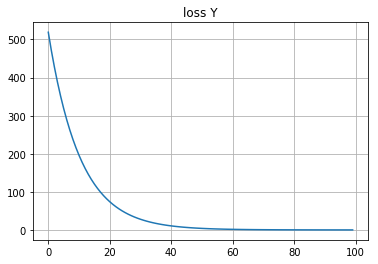

********************************************************************
start second admm for mu = 0.002
********************************************************************
start of admm for canonical pair 0 and i = 0
********************************************************************
iter: 0, loss X:1206.06, loss Y:1207.34, cos X:1.00, cos Y:1.00, TDR:1.86, CDR:0.0000, Mean Absolute Correlation:1.00
iter: 40, loss X:27.68, loss Y:1207.34, cos X:1.00, cos Y:1.00, TDR:1.72, CDR:1.1600, Mean Absolute Correlation:1.00
iter: 80, loss X:3.93, loss Y:1207.34, cos X:1.00, cos Y:1.00, TDR:1.82, CDR:1.1600, Mean Absolute Correlation:1.00
iter: 120, loss X:3.40, loss Y:1207.34, cos X:1.00, cos Y:1.00, TDR:1.83, CDR:1.1600, Mean Absolute Correlation:1.00
iter: 160, loss X:3.38, loss Y:1207.34, cos X:1.00, cos Y:1.00, TDR:1.83, CDR:1.1600, Mean Absolute Correlation:1.00
iter: 200, loss X:3.38, loss Y:1207.34, cos X:1.00, cos Y:1.00, TDR:1.83, CDR:1.1600, Mean Absolute Correlation:1.00
iter: 240, lo

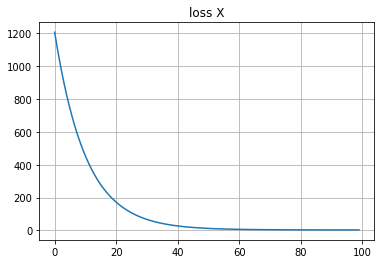

********************************************************************
start of admm for canonical pair 0 and i = 1
********************************************************************
iter: 0, loss X:3.37, loss Y:1207.34, cos X:1.00, cos Y:1.00, TDR:1.83, CDR:1.1600, Mean Absolute Correlation:1.00
iter: 40, loss X:3.37, loss Y:27.71, cos X:1.00, cos Y:1.00, TDR:1.89, CDR:0.0000, Mean Absolute Correlation:1.00
iter: 80, loss X:3.37, loss Y:3.94, cos X:1.00, cos Y:1.00, TDR:1.87, CDR:0.0000, Mean Absolute Correlation:1.00
iter: 120, loss X:3.37, loss Y:3.41, cos X:1.00, cos Y:1.00, TDR:1.86, CDR:0.0000, Mean Absolute Correlation:1.00
iter: 160, loss X:3.37, loss Y:3.39, cos X:1.00, cos Y:1.00, TDR:1.86, CDR:0.0000, Mean Absolute Correlation:1.00
iter: 200, loss X:3.37, loss Y:3.39, cos X:1.00, cos Y:1.00, TDR:1.86, CDR:0.0000, Mean Absolute Correlation:1.00
iter: 240, loss X:3.37, loss Y:3.39, cos X:1.00, cos Y:1.00, TDR:1.86, CDR:0.0000, Mean Absolute Correlation:1.00
iter: 280, loss X:3

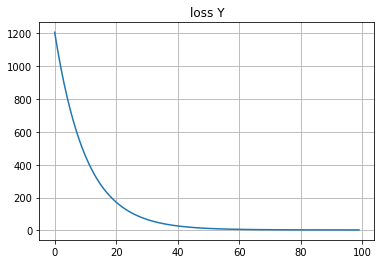

In [68]:
print('********************************************************************')
print('********************************************************************')
print(f'Evaluation for lamba = {i} and mu = {j}')
params = {'data':segmented_data,
          'lambda_': i,
          'mu': j,
          'l':1,
         'nu':10,
         'fully':True}
tdcca = TDCCA(**params)
W = tdcca.algoritm_2(n_iters=2000)

### Simulation of non-correlated data

********************************************************************
Data is simulated
X shape is (10000, 20)
Y shape is (10000, 20)
WX_true shape is (20, 10000)
WY_true shape is (20, 10000)
********************************************************************
Data is segmentated
Returned list consists of 2 dictionaries for X and Y respectefully
***
Dictionary for X0 consists of 100 dictionaries each corresponding to time t
In each dictionary lies 6 parameters: 
         X of shape (100, 20) 
         U of shape (20, 18) 
         Q of shape (100, 18) 
         Sigma of shape (18, 18) 
         P of shape (18, 18) 
         W_real of shape (20,)
***
Dictionary for X1 consists of 100 dictionaries each corresponding to time t
In each dictionary lies 6 parameters: 
         X of shape (100, 20) 
         U of shape (20, 18) 
         Q of shape (100, 18) 
         Sigma of shape (18, 18) 
         P of shape (18, 18) 
         W_real of shape (20,)


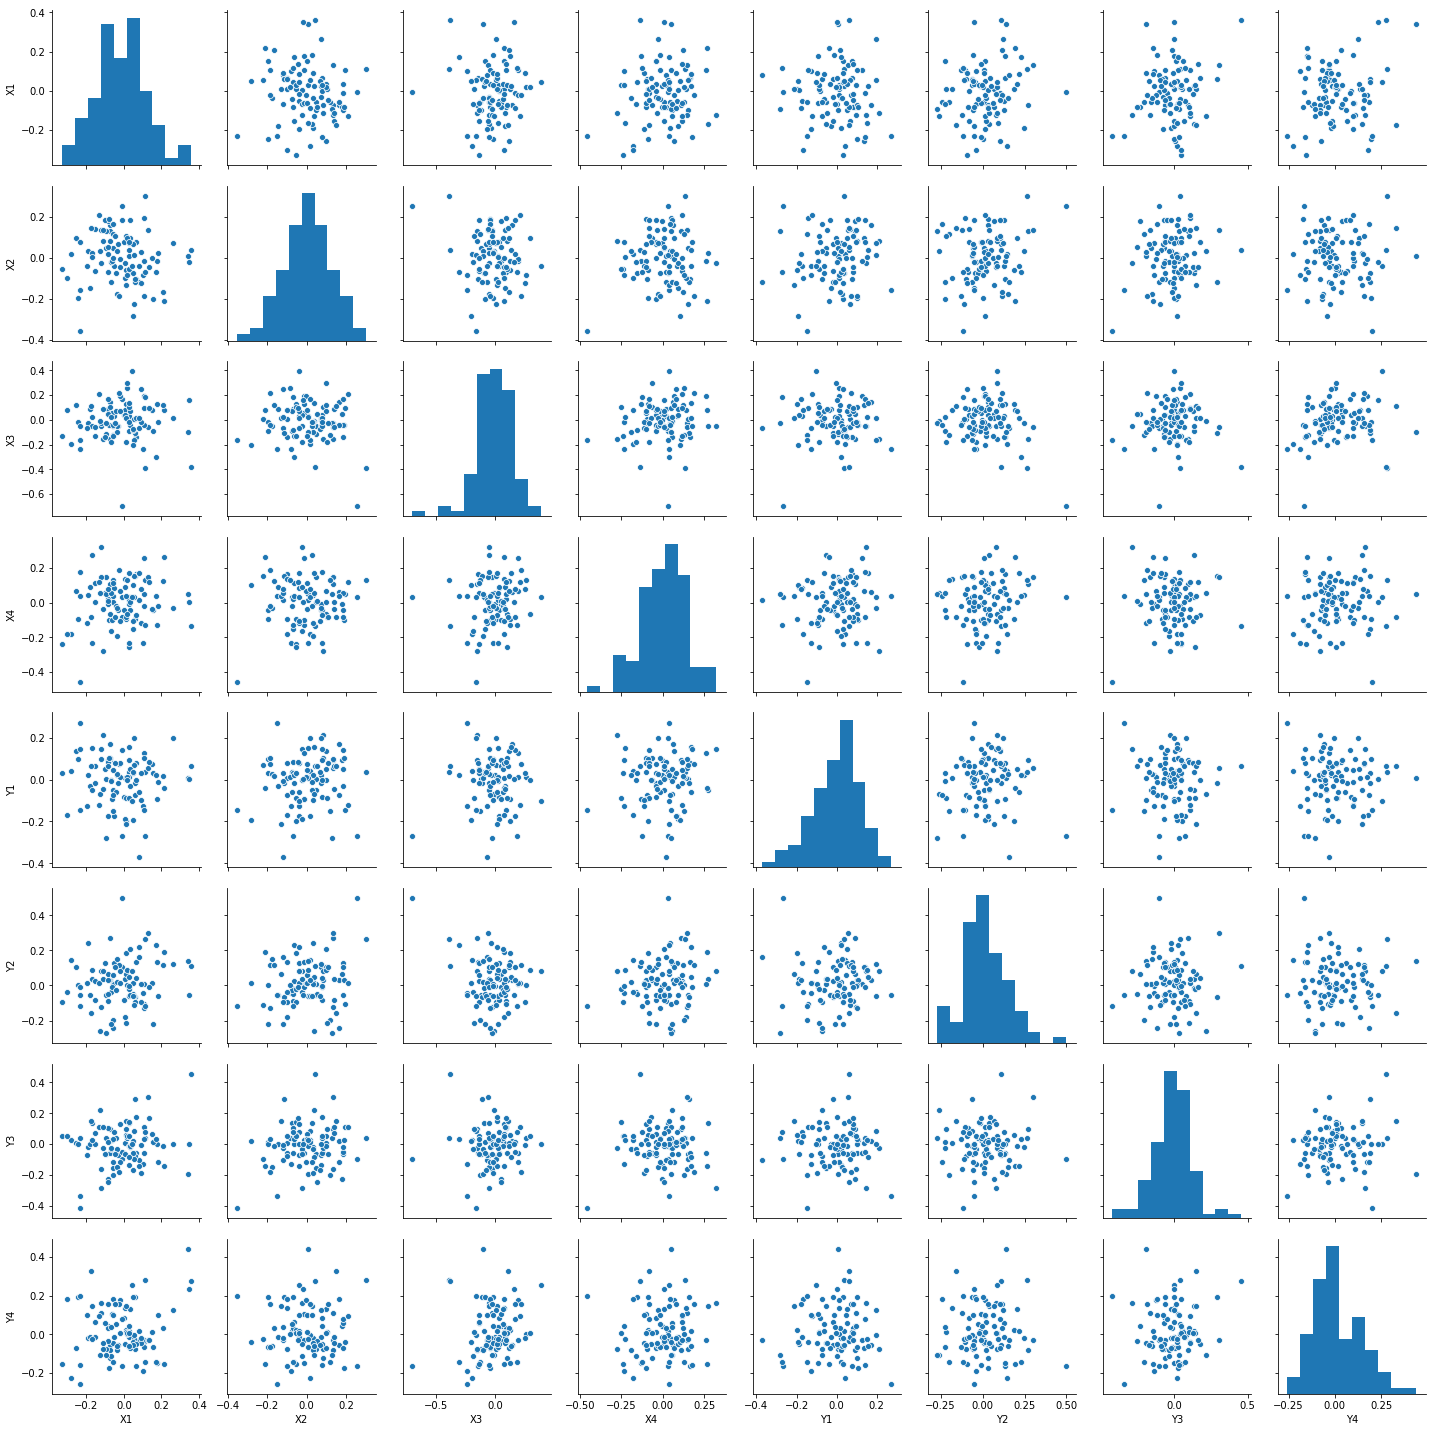

In [17]:
simulated_data = sim1(t = 100, d = 20, n =100,generator_type='noise')
segmented_data = data_segmentation( simulated_data, T = 100, W = 100)
plot_graphs(simulated_data)

********************************************************************
********************************************************************
Evaluation for lamba = 0.001 and mu = 0.002
********************************************************************
start first admm for mu = 1e-13
********************************************************************
start of admm for canonical pair 0 and i = 0
********************************************************************
iter: 0, loss X:9653.80, loss Y:9701.07, cos X:nan, cos Y:nan, TDR:nan, F_score:0.00, roc_auc:-1.00, CDR:nan, Mean Absolute Correlation:nan
iter: 40, loss X:198.68, loss Y:9701.07, cos X:nan, cos Y:nan, TDR:1.38, F_score:0.00, roc_auc:-1.00, CDR:nan, Mean Absolute Correlation:nan
iter: 80, loss X:7.54, loss Y:9701.07, cos X:nan, cos Y:nan, TDR:1.38, F_score:0.00, roc_auc:-1.00, CDR:nan, Mean Absolute Correlation:nan
iter: 120, loss X:3.63, loss Y:9701.07, cos X:nan, cos Y:nan, TDR:1.38, F_score:0.00, roc_auc:-1.00, CDR:nan, Mean

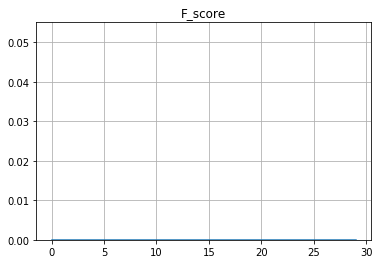

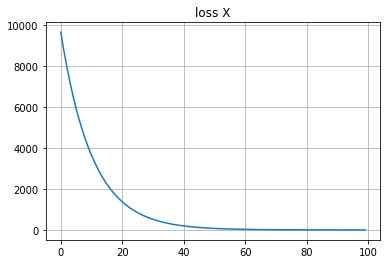

********************************************************************
start of admm for canonical pair 0 and i = 1
********************************************************************
iter: 0, loss X:3.53, loss Y:9701.07, cos X:nan, cos Y:nan, TDR:1.38, F_score:0.00, roc_auc:-1.00, CDR:nan, Mean Absolute Correlation:nan
iter: 40, loss X:3.53, loss Y:199.66, cos X:nan, cos Y:nan, TDR:1.22, F_score:0.00, roc_auc:-1.00, CDR:nan, Mean Absolute Correlation:0.79
iter: 80, loss X:3.53, loss Y:7.58, cos X:nan, cos Y:nan, TDR:1.22, F_score:0.00, roc_auc:-1.00, CDR:nan, Mean Absolute Correlation:0.79
iter: 120, loss X:3.53, loss Y:3.65, cos X:nan, cos Y:nan, TDR:1.22, F_score:0.00, roc_auc:-1.00, CDR:nan, Mean Absolute Correlation:0.79
iter: 160, loss X:3.53, loss Y:3.56, cos X:nan, cos Y:nan, TDR:1.22, F_score:0.00, roc_auc:-1.00, CDR:nan, Mean Absolute Correlation:0.79
iter: 200, loss X:3.53, loss Y:3.56, cos X:nan, cos Y:nan, TDR:1.22, F_score:0.00, roc_auc:-1.00, CDR:nan, Mean Absolute Correl

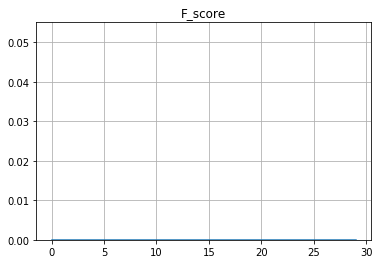

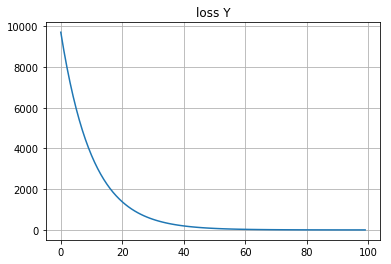

********************************************************************
start second admm for mu = 0.002
********************************************************************
start of admm for canonical pair 0 and i = 0
********************************************************************
iter: 0, loss X:19055.61, loss Y:18803.00, cos X:nan, cos Y:nan, TDR:1.22, F_score:0.00, roc_auc:-1.00, CDR:nan, Mean Absolute Correlation:0.79
iter: 40, loss X:397.59, loss Y:18803.00, cos X:nan, cos Y:nan, TDR:1.22, F_score:0.00, roc_auc:-1.00, CDR:nan, Mean Absolute Correlation:0.79
iter: 80, loss X:21.22, loss Y:18803.00, cos X:nan, cos Y:nan, TDR:1.22, F_score:0.00, roc_auc:-1.00, CDR:nan, Mean Absolute Correlation:0.79
iter: 120, loss X:13.43, loss Y:18803.00, cos X:nan, cos Y:nan, TDR:1.23, F_score:0.00, roc_auc:-1.00, CDR:nan, Mean Absolute Correlation:0.79
iter: 160, loss X:13.24, loss Y:18803.00, cos X:nan, cos Y:nan, TDR:1.23, F_score:0.00, roc_auc:-1.00, CDR:nan, Mean Absolute Correlation:0.79


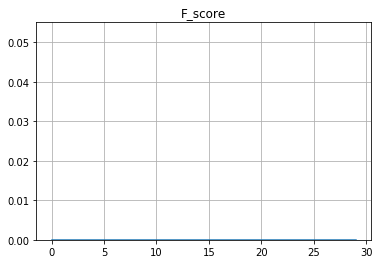

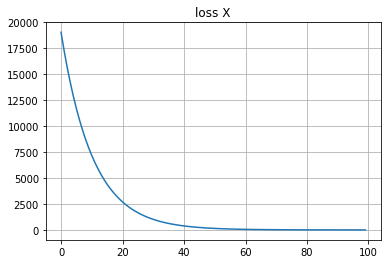

********************************************************************
start of admm for canonical pair 0 and i = 1
********************************************************************
iter: 0, loss X:13.13, loss Y:18803.00, cos X:nan, cos Y:nan, TDR:1.23, F_score:0.00, roc_auc:-1.00, CDR:nan, Mean Absolute Correlation:0.79
iter: 40, loss X:13.13, loss Y:392.77, cos X:nan, cos Y:nan, TDR:1.23, F_score:0.00, roc_auc:-1.00, CDR:nan, Mean Absolute Correlation:0.79
iter: 80, loss X:13.13, loss Y:21.37, cos X:nan, cos Y:nan, TDR:1.21, F_score:0.00, roc_auc:-1.00, CDR:nan, Mean Absolute Correlation:0.79
iter: 120, loss X:13.13, loss Y:13.68, cos X:nan, cos Y:nan, TDR:1.22, F_score:0.00, roc_auc:-1.00, CDR:nan, Mean Absolute Correlation:0.79
iter: 160, loss X:13.13, loss Y:13.50, cos X:nan, cos Y:nan, TDR:1.22, F_score:0.00, roc_auc:-1.00, CDR:nan, Mean Absolute Correlation:0.79
iter: 200, loss X:13.13, loss Y:13.49, cos X:nan, cos Y:nan, TDR:1.22, F_score:0.00, roc_auc:-1.00, CDR:nan, Mean Abs

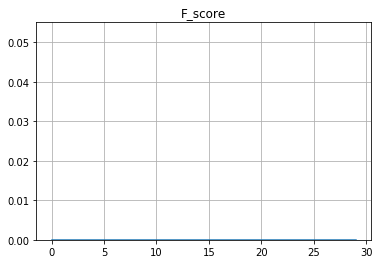

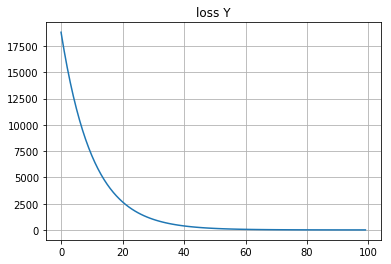

In [42]:
print('********************************************************************')
print('********************************************************************')
print(f'Evaluation for lamba = {i} and mu = {j}')
params = {'data':segmented_data,
          'lambda_': i,
          'mu': j,
          'l':1,
         'nu':10}
tdcca = TDCCA(**params)
W = tdcca.algoritm_2(n_iters=2000)

### Provide metrics validation of your method

**Provide graphs showing the data and the TDCCA decomposition result**

In [38]:
#### YOUR GRAPHS IS HERE

# Grading rules

- correct sumulated data
  - 10% for each simulated data set (30% total)
- correct metrics
  - 5% for each metric (20% total )
  
- correct TDCCA
  - 30% for correct implementation
  
- representative graphs of data and result of TDCCA
  - 15%
  
- and 5% for quality of your code and comments which help me to understand your genius

# Redline

### 21:00 04/10/2020

# Deadline

### 14:00 08/10/2020

Please ask questions in our group before `redline`
Please provide your team solution before `deadline`